In [ ]:
#!pip install kaggle
#!pip install torch torchvision matplotlib


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle .json to kaggle .json


{'kaggle .json': b'{"username":"surabhibhor20","key":"1039ebb07bbd01eadba105125f2ec0b7"}'}

In [ ]:
!kaggle datasets download -d soumikrakshit/images-for-style-transfer



Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/images-for-style-transfer
License(s): CC0-1.0
images-for-style-transfer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

# Path to the ZIP file
zip_path = "images-for-style-transfer.zip"
extract_to = "style_transfer_data/"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")


Extraction completed!


In [ ]:
import shutil
import os

# Define source and destination
artworks_dir = "style_transfer_data/Data/Artworks"
style_dir = "style_transfer_data/style"
os.makedirs(style_dir, exist_ok=True)

# Move all images from Artworks to style
for file in os.listdir(artworks_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        shutil.move(os.path.join(artworks_dir, file), style_dir)

print("Style images moved successfully!")


Style images moved successfully!


In [ ]:
# Define source and destination
testcases_dir = "style_transfer_data/Data/TestCases"
content_dir = "style_transfer_data/content"
os.makedirs(content_dir, exist_ok=True)

# Move all images from TestCases to content
for file in os.listdir(testcases_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        shutil.move(os.path.join(testcases_dir, file), content_dir)

print("Content images moved successfully!")


Content images moved successfully!


 Loading & visualizing

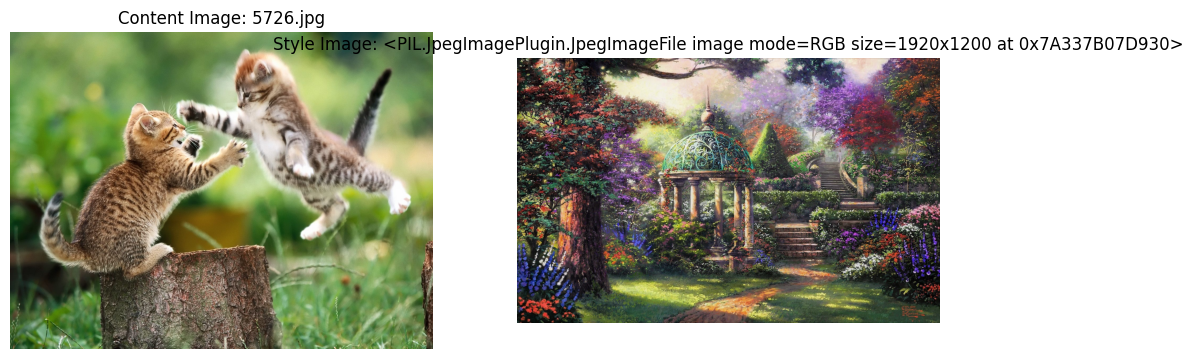

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
content_dir = 'style_transfer_data/content'
style_dir = 'style_transfer_data/style'

# Display sample content and style images
def display_samples():
    # Ensure the directories are not empty
    if not os.path.exists(content_dir) or not os.listdir(content_dir):
        raise FileNotFoundError(f"No files found in content directory: {content_dir}")
    if not os.path.exists(style_dir) or not os.listdir(style_dir):
        raise FileNotFoundError(f"No files found in style directory: {style_dir}")

    # Get a random content image (other than the first one)
    content_images = os.listdir(content_dir)
    random_content_image = random.choice(content_images)  # Randomly pick a content image

    # Select the first style image
    style_image = os.listdir(style_dir)[0]

    # Open the selected images
    content_image_path = os.path.join(content_dir, random_content_image)
    style_image_path = os.path.join(style_dir, style_image)

    content_image = Image.open(content_image_path)
    style_image = Image.open(style_image_path)

    # Plot the images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(content_image)
    ax[0].set_title(f'Content Image: {random_content_image}')
    ax[0].axis('off')

    ax[1].imshow(style_image)
    ax[1].set_title(f'Style Image: {style_image}')
    ax[1].axis('off')

    plt.show()

# Display the samples
display_samples()


*Building the Style Transfer GAN* then Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

# Assuming content_dataloader and style_dataloader are defined and device is set
# Example:
# content_dataloader = ...
# style_dataloader = ...
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dummy datasets with labels
content_data = torch.randn(100, 3, 128, 128)  # 100 samples
style_data = torch.randn(100, 3, 128, 128)    # 100 samples

# Create dummy labels (not used in the training loop, but required by TensorDataset)
labels = torch.zeros(100)  # Dummy labels

content_dataset = TensorDataset(content_data, labels)
style_dataset = TensorDataset(style_data, labels)

batch_size = 10

content_dataloader = DataLoader(content_dataset, batch_size=batch_size, shuffle=True)
style_dataloader = DataLoader(style_dataset, batch_size=batch_size, shuffle=True)

# Assuming device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the generator and discriminator
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        # Example architecture for the generator
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Output layer with 1 feature for binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate models
input_size = 3 * 128 * 128  # Flatten size of (3, 128, 128)
output_size = 3 * 128 * 128  # Output size of the generator

generator = Generator(input_size=input_size, output_size=output_size).to(device)
discriminator = Discriminator(input_size=input_size).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Using betas for better training stability
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Print the optimizers and the loss function to check
print("\nGenerator Optimizer:")
print(generator_optimizer)

print("\nDiscriminator Optimizer:")
print(discriminator_optimizer)

print("\nAdversarial Loss:")
print(adversarial_loss)

# Initialize lists to store losses for plotting
d_losses = []
g_losses = []

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    content_iter = iter(content_dataloader)
    style_iter = iter(style_dataloader)

    for i in range(min(len(content_dataloader), len(style_dataloader))):
        try:
            content_img, _ = next(content_iter)  # Unpack image and ignore label
            style_img, _ = next(style_iter)      # Unpack image and ignore label
        except StopIteration:
            break

        # Ensure the input images have the correct shape
        batch_size = content_img.size(0)
        assert content_img.shape == (batch_size, 3, 128, 128), f"Expected shape ({batch_size}, 3, 128, 128), got {content_img.shape}"
        assert style_img.shape == (batch_size, 3, 128, 128), f"Expected shape ({batch_size}, 3, 128, 128), got {style_img.shape}"

        content_img, style_img = content_img.to(device), style_img.to(device)

        # Flatten the input images to match the input size of the generator and discriminator
        content_img_flat = content_img.view(content_img.size(0), -1)
        style_img_flat = style_img.view(style_img.size(0), -1)

        # Ensure the flattened images have the correct shape
        assert content_img_flat.shape == (batch_size, 49152), f"Expected shape ({batch_size}, 49152), got {content_img_flat.shape}"
        assert style_img_flat.shape == (batch_size, 49152), f"Expected shape ({batch_size}, 49152), got {style_img_flat.shape}"

        # Print tensor shapes for debugging
        print(f"Iteration {i}: content_img_flat shape: {content_img_flat.shape}")
        print(f"Iteration {i}: style_img_flat shape: {style_img_flat.shape}")

        # Training discriminator
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(content_img.size(0), 1).to(device)
        fake_labels = torch.zeros(content_img.size(0), 1).to(device)

        # Real images loss
        real_outputs = discriminator(content_img_flat)  # Output size: (batch_size, 1)
        real_loss = adversarial_loss(real_outputs, real_labels)

        # Fake images loss
        fake_images = generator(style_img_flat)
        fake_outputs = discriminator(fake_images.detach())  # Detach to avoid gradient computation
        fake_loss = adversarial_loss(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        discriminator_optimizer.step()

        # Training generator
        generator_optimizer.zero_grad()
        fake_images = generator(style_img_flat)
        gen_outputs = discriminator(fake_images)
        g_loss = adversarial_loss(gen_outputs, real_labels)
        g_loss.backward()
        generator_optimizer.step()

    # Store losses for plotting
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Print loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")



Generator Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

Discriminator Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

Adversarial Loss:
BCELoss()
Iteration 0: content_img_flat shape: torch.Size([10, 49152])
Iteration 0: style_img_flat shape: torch.Size([10, 49152])
Iteration 1: content_img_flat shape: torch.Size([10, 49152])
Iteration 1: style_img_flat shape: torch.Size([10, 49152])
Iteration 2: content_img_flat shape: torch.Size([10, 49152])
Iteration 2: style_img_flat shape: torch.Size([10, 49152])
Iteration 3: content_img_flat shape: torch.Size([10, 49152])
Iteration 3: style_img_flat shape: torch.Size([10, 49152])

In [ ]:
## Save the Models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
# Step 2: Evaluate the Generator
# Generate images using the trained generator
fixed_style_img = style_img_flat[:batch_size].to(device)  # Use the first batch of style images
generated_images = generator(fixed_style_img).view(batch_size, 3, 128, 128)

In [ ]:
# Denormalize and convert to CPU for visualization
# Assuming the images are in the range [-1, 1], denormalize to [0, 1]
generated_images = (generated_images + 1) / 2.0
generated_images = generated_images.detach().cpu()


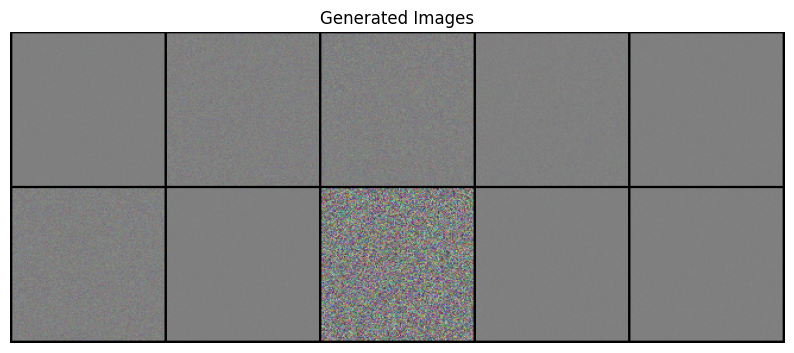

In [ ]:
#  Visualize Generated Images
# Create a grid of images
grid = make_grid(generated_images, nrow=5, normalize=False)

# Plot the images
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.title('Generated Images')
plt.axis('off')
plt.show()

on new image

In [ ]:
# Preprocess the New Image
from PIL import Image
import torchvision.transforms as transforms

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load and preprocess the new image
new_image_path = '/content/Screenshot 2024-11-18 185745.png'  # Replace with your image path
new_image = Image.open(new_image_path).convert('RGB')
new_image_tensor = transform(new_image).unsqueeze(0)  # Add batch dimension

In [ ]:
# Convert the Image to a Tensor
# Move the tensor to the appropriate device
new_image_tensor = new_image_tensor.to(device)

In [ ]:
# Flatten the Image
# Flatten the image to match the input size expected by the generator
new_image_flat = new_image_tensor.view(new_image_tensor.size(0), -1)

In [ ]:
# Generate a New Image
# Load the trained generator model
generator = Generator(input_size=input_size, output_size=output_size).to(device)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()  # Set the generator to evaluation mode

# Generate a new image
generated_image_tensor = generator(new_image_flat).view(new_image_tensor.size(0), 3, 128, 128)

<ipython-input-87-5b61675c50e5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))


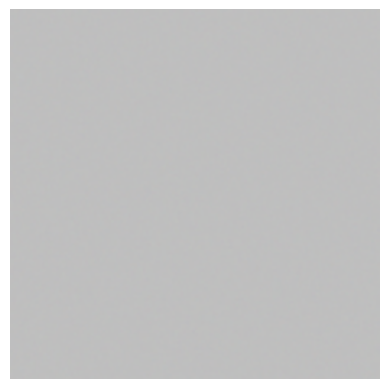

In [ ]:
import matplotlib.pyplot as plt

# Denormalize the image
generated_image_tensor = (generated_image_tensor + 1) / 2.0  # Convert from [-1, 1] to [0, 1]

# Convert the tensor to a PIL image
generated_image = transforms.ToPILImage()(generated_image_tensor.squeeze(0))

# Display the image using Matplotlib
plt.imshow(generated_image)
plt.axis('off')  # Turn off axis labels
plt.show()
